In [71]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
cm = cmap.inferno

import numpy as np
import scipy as sp
import theano
import theano.tensor as tt
import theano.tensor.nlinalg
import sys
import pymc3 as pm
import pandas as pd

# Goals

In this notebook, I will take the embedding values from the previous notebook (`keras-sequence-autoencoder`) and see if I can perform GP regression on them.

# Data

The input data here are the 'embedding values' from the previous notebook. At the moment, it is very coarse-grained (by year only) and as such is very crude, but for forecasting purposes it's a relevant time scale.

In the raw dataframe, each row is one sequence, and each sequence has its two embedding coordinates (`Means 0` and `Means 1` paired with the year of isolation.

In [2]:
# Read in the data from CSV.
df = pd.read_csv('embedding_vals.csv', index_col=0)
df.head()

,years,Means 0,Means 1
0,2011,1.949354,0.598884
1,2015,0.508923,1.252961
2,2012,1.538876,1.400515
3,2015,0.126540,3.254572
4,2016,-0.437363,2.561972


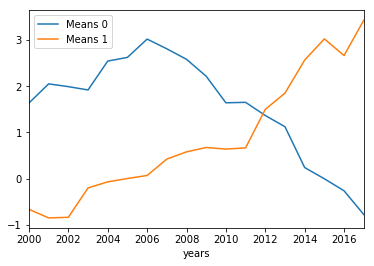

In [3]:
# Just checking: plot the mean over year. 
df.groupby('years').mean().plot()

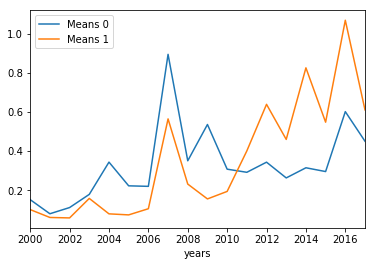

In [121]:
# Also just for sanity checking purposes; we may be able to do GP regression on the standard deviation over time. 
df.groupby('years').std().plot()

Here, I will try this thing called 'back-testing'. The core idea here is to hold out the latest data point and use the model trained on the rest of the data to predict that latest datapoint.

In [123]:
steps = 1  # We will hold out only 1 time step.

# Sanity check.
df.groupby('years').mean()['Means 1'].values[:-steps]

array([ -6.67016230e-01,  -8.53864137e-01,  -8.40666575e-01,
        -2.04148578e-01,  -7.27075153e-02,   5.00480695e-04,
         6.57548489e-02,   4.21047562e-01,   5.77297771e-01,
         6.72706728e-01,   6.38108455e-01,   6.63090845e-01,
         1.49939658e+00,   1.85017485e+00,   2.56664704e+00,
         3.02585806e+00,   2.66453394e+00])

In [124]:
# X = np.array(df.groupby('years').mean().index)
X = np.arange(len(df.groupby('years').mean().index[:-steps])).reshape(-1, 1)
# Y = df.groupby('years').mean()['Means 0'].values
Y = df.groupby('years').mean()['Means 1'].values[:-steps]

In [126]:
# Sanity check: We have 18 data points over time, so there should only be 17 data points going into the training set.
# 
X.shape, Y.shape

((17, 1), (17,))

In [90]:
# Model specification. We use PyMC3's GP example as the basis for this.
with pm.Model() as model:
    l = pm.Uniform('l', 0, 10)
    
    # Covariance function
    log_s2_f = pm.Uniform('log_s2_f', lower=-10, upper=5)
    s2_f = pm.Deterministic('s2_f', tt.exp(log_s2_f))
    f_cov = s2_f * pm.gp.cov.ExpQuad(input_dim=1, lengthscales=l)
    
    # Sigma
    log_s2_n = pm.Uniform('log_s2_n', lower=-10, upper=5)
    s2_n = pm.Deterministic('s2_n', tt.exp(log_s2_n))
    
    y_obs = pm.gp.GP('y_obs', cov_func=f_cov, sigma=s2_n, observed={'X':X, 'Y':Y})

In [91]:
# Fit model.
with model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -15.402: 100%|██████████| 200000/200000 [01:18<00:00, 2558.80it/s]
Finished [100%]: Average ELBO = -15.407
100%|██████████| 2000/2000 [00:08<00:00, 228.86it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f637ca72278>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f63be78e1d0>]], dtype=object)

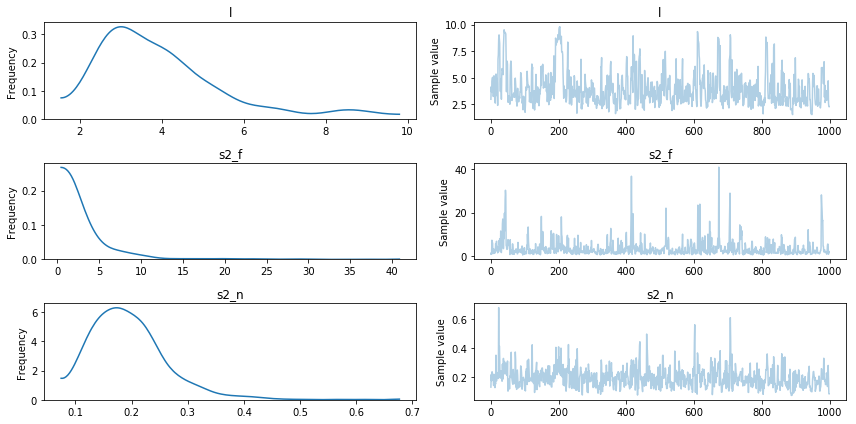

In [92]:
# Traceplot.
pm.traceplot(trace[1000:], varnames=['l', 's2_f', 's2_n'])

In [93]:
# Most important: sample from posterior.
Z = np.linspace(0, 19, 20)[:, None]
with model:
    gp_samples = pm.gp.sample_gp(trace, y_obs, Z, samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]/home/ericmjl/anaconda/lib/python3.6/site-packages/scipy/stats/_multivariate.py:533: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
100%|██████████| 1000/1000 [00:30<00:00, 32.31it/s]


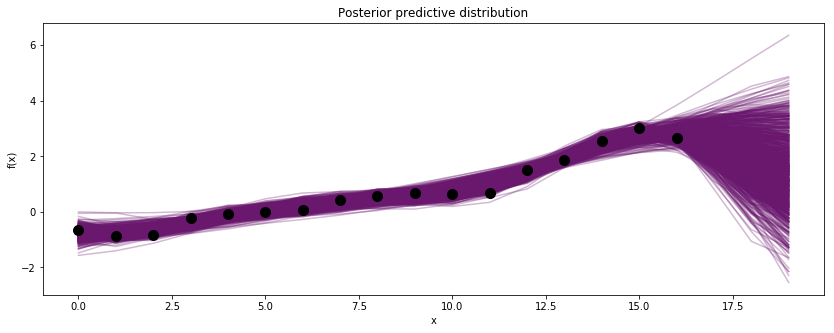

In [94]:
# Plot posterior
fig, ax = plt.subplots(figsize=(14,5))

[ax.plot(Z, x, color=cm(0.3), alpha=0.3) for x in gp_samples]
# overlay the observed data
ax.plot(X, Y, 'ok', ms=10);
ax.set_xlabel("x");
ax.set_ylabel("f(x)");
ax.set_title("Posterior predictive distribution");

Is the next year's value within the 95% HPD of the posterior?

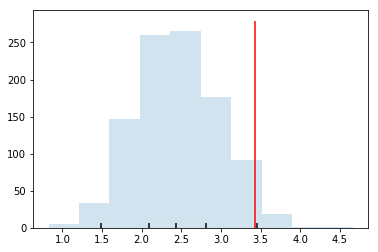

In [120]:
# Q: is the next year within the 95% HPD of posterior?
plt.hist(gp_samples[:, 17], alpha=0.2)  # 18 is the next timepoint 

ax = plt.gca()
ylow, yhigh = ax.get_ylim()
plt.vlines(x=df.groupby('years').mean()['Means 1'].values[-1], ymin=0, ymax=yhigh, color='red')
percs = np.percentile(gp_samples[:,17], [2.5, 25, 50, 75, 97.5])
for p in percs:
    plt.vlines(x=p, ymin=0, ymax=yhigh * 0.025)